# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Nguyễn Minh Nhật
- MSSV:      22127309
- Lớp:       22CLC05

## Import các thư viện liên quan

In [49]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Helper functions

In [50]:
def read_img(img_path : str) -> np.ndarray:
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    return np.array(Image.open(img_path).convert("RGB"))


def show_img(img_2d : np.ndarray) -> None:
    '''
    Show image

    Parameters
    ----------
    img_2d : np.ndarray
        Image (2D)
    '''

    plt.imshow(img_2d)
    


def save_img(img_2d : np.ndarray, img_path : str) -> None:
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : ndarray
        Image (2D)
    img_path : str
        Path of image
    '''
    Image.fromarray(img_2d).save(img_path)


def convert_img_to_1d(img_2d : np.ndarray) -> np.ndarray:
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''
    return img_2d.reshape(-1, img_2d.shape[-1])


def kmeans(img_1d: np.ndarray, k_clusters : int, max_iter : int, init_centroids : str = 'random') -> tuple[np.ndarray, np.ndarray]:
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    def get_closest_centroid(centroids : np.ndarray, pixels : np.ndarray) -> np.ndarray:
        distances = np.add.reduce((centroids - pixels[:, np.newaxis, :].astype(np.int32)) ** 2, 
                                  axis=2)
        return np.argmin(distances, axis=1)
    

    def ein_get_closest_centroid(centroids : np.ndarray, pixels : np.ndarray) -> np.ndarray:
        diff = centroids - pixels[:, np.newaxis, :].astype(np.int32)
        distances = np.einsum('ijk,ijk->ij', diff, diff)
        return np.argmin(distances, axis=1)

    tollorance = 1e-5
    gen = np.random.default_rng()
    if init_centroids == 'random':
        centroids = gen.choice(np.arange(0, 256, dtype=np.int16), size=(k_clusters, img_1d.shape[-1]), replace = True)
    elif init_centroids == 'in_pixels':
        centroids = gen.choice(img_1d.tolist(), size = k_clusters , replace=False)
    else:
        raise ValueError('Invalid init_centroids value')

    labels = np.zeros(img_1d.shape[0], dtype=np.int32)

    for i in range(max_iter):
        labels = ein_get_closest_centroid(centroids, img_1d) 
        new_centroids = np.empty_like(centroids)
        for k in range(k_clusters):
            indices = np.where(labels == k)[0]
            cluster_pixels = img_1d[indices]
            if (len(cluster_pixels) == 0): continue 
            new_centroids[k] = np.add.reduce(cluster_pixels, axis = 0) / len(cluster_pixels)
        print(f"Iteration: {i + 1}",end = '\r')  
        if np.linalg.norm(new_centroids - centroids) < tollorance:
            return centroids, labels
        centroids = new_centroids
    return centroids, labels


def generate_2d_img(img_2d_shape : tuple, centroids : np.ndarray, labels : np.ndarray) -> np.ndarray:
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    labels_reshaped = labels.reshape(img_2d_shape[0], img_2d_shape[1])
    new_img_2d = centroids[labels_reshaped]
    return new_img_2d.astype(np.uint8)
    
    


# Your additional functions here
def show_img_comparison(original_img : np.ndarray, new_img : np.ndarray) -> None:
    '''
    Show original and new image side by side for comparison

    Parameters
    ----------
    original_img : np.ndarray
        Original Image (2D)
    new_img : np.ndarray
        New Image (2D)
    '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[1].imshow(new_img)
    axs[1].set_title('New Image')

    plt.show()

def color_segmentation(img_path, k_clusters = 10, max_iter = 10, init_centroids = 'random', show_comparison = True) -> np.ndarray:
    '''
    Color segmentation for image using k means clustering

    Parameters
    ----------
    img_path : str
        Path of image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel, is set by default
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster
    '''
    img_2d = read_img(img_path)
    print(f"Image loaded : {img_2d.shape}")
    img_1d = convert_img_to_1d(img_2d)
    print(f"Image converted to 1D : {img_1d.shape}")
    centroids, labels = kmeans(img_1d, k_clusters, max_iter, init_centroids)
    print(f"\nK-Means clustering done\nGenerating image...", end = '')
    new_img = generate_2d_img(img_2d.shape, centroids, labels)
    print(f"\rImage generated : {new_img.shape}")
    if show_comparison:
        show_img_comparison(img_2d, new_img)
    return new_img


## Your tests

## Main FUNCTION

In [64]:
def main():
    img_path = 'Images/sakura.png'
    k_clusters = 7
    max_iter = 100
    init_centroids = 'in_pixels'
    show_comparison = True
    new_img = color_segmentation(img_path, k_clusters, max_iter, init_centroids, show_comparison)
    new_img_path = f"images/image_{str(np.random.default_rng().integers(0, 10000))}.jpg"
    print(f"Saving image to {new_img_path}")
    save_img(new_img, new_img_path)

Image loaded : (427, 643, 3)
Image converted to 1D : (274561, 3)
Iteration: 55
K-Means clustering done
Image generated : (427, 643, 3)


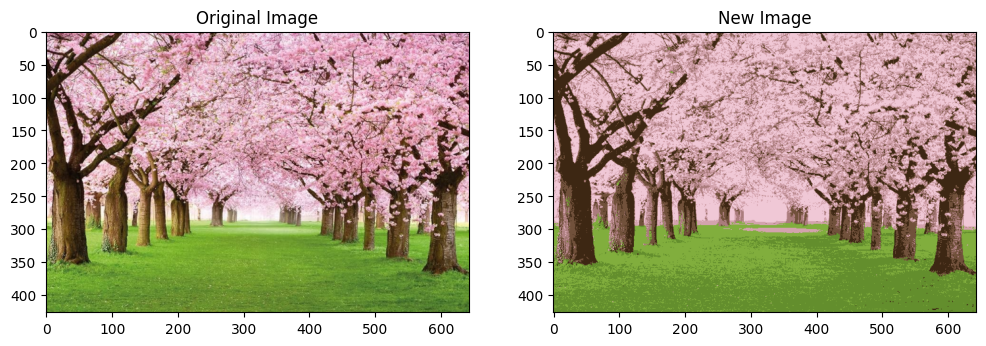

Saving image to images/image_903.jpg


In [65]:
if __name__ == '__main__':
    main()